In [25]:
from pyspark.sql import SparkSession
import seaborn as sns

In [2]:
spark = SparkSession \
        .builder \
        .appName("Bayes classification using Spark") \
        .getOrCreate()

In [3]:
BUCKET="gcp-de-1"

In [4]:
inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)

In [5]:
#inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)

In [6]:
inputs

'gs://gcp-de-1/flights/tzcorr/all_flights-00000-*'

In [7]:
from pyspark.sql.types import *

In [10]:
def get_structfield(colname):
    if colname in ['ARR_DELAY', "DEP_DELAY", "DISTANCE"]:
        return StructField(colname, FloatType(),True)
    else:
        return StructField(colname,StringType(),True)
    


In [8]:
header = ["FL_DATE",
          "UNIQUE_CARRIER",
          "AIRLINE_ID",
          "CARRIER",
          "FL_NUM",
          "ORIGIN_AIRPORT_ID",
          "ORIGIN_AIRPORT_SEQ_ID",
          "ORIGIN_CITY_MARKET_ID",
          "ORIGIN","DEST_AIRPORT_ID",
          "DEST_AIRPORT_SEQ_ID",
          "DEST_CITY_MARKET_ID",
          "DEST","CRS_DEP_TIME",
          "DEP_TIME","DEP_DELAY",
          "TAXI_OUT","WHEELS_OFF",
          "WHEELS_ON","TAXI_IN",
          "CRS_ARR_TIME",
          "ARR_TIME",
          "ARR_DELAY",
          "CANCELLED",
          "CANCELLATION_CODE",
          "DIVERTED",
          "DISTANCE",
          "DEP_AIRPORT_LAT",
          "DEP_AIRPORT_LON",
          "DEP_AIRPORT_TZOFFSET",
          "ARR_AIRPORT_LAT",
          "ARR_AIRPORT_LON",
          "ARR_AIRPORT_TZOFFSET"]

In [11]:
schema = StructType([get_structfield(colname) for colname in header])

In [12]:
schema

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

In [13]:
flights = spark.read \
            .schema(schema) \
            .csv(inputs)

In [14]:
flights

DataFrame[FL_DATE: string, UNIQUE_CARRIER: string, AIRLINE_ID: string, CARRIER: string, FL_NUM: string, ORIGIN_AIRPORT_ID: string, ORIGIN_AIRPORT_SEQ_ID: string, ORIGIN_CITY_MARKET_ID: string, ORIGIN: string, DEST_AIRPORT_ID: string, DEST_AIRPORT_SEQ_ID: string, DEST_CITY_MARKET_ID: string, DEST: string, CRS_DEP_TIME: string, DEP_TIME: string, DEP_DELAY: float, TAXI_OUT: string, WHEELS_OFF: string, WHEELS_ON: string, TAXI_IN: string, CRS_ARR_TIME: string, ARR_TIME: string, ARR_DELAY: float, CANCELLED: string, CANCELLATION_CODE: string, DIVERTED: string, DISTANCE: float, DEP_AIRPORT_LAT: string, DEP_AIRPORT_LON: string, DEP_AIRPORT_TZOFFSET: string, ARR_AIRPORT_LAT: string, ARR_AIRPORT_LON: string, ARR_AIRPORT_TZOFFSET: string]

In [15]:
flights.createOrReplaceTempView('flights')

In [16]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE DEP_DELAY > -20 AND DISTANCE < 2000')
results.show()

+--------+
|count(1)|
+--------+
|  446142|
+--------+



In [18]:
traindays = spark.read \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

traindays.createOrReplaceTempView('traindays')

In [19]:
results = spark.sql('SELECT * FROM traindays')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 7, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 8, 0, 0), is_train_day=True)]

In [21]:
statement = """
SELECT 
    f.FL_DATE AS date,
    f.DISTANCE AS distance,
    f.DEP_DELAY AS dep_delay
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
    t.is_train_day AND
    f.DEP_DELAY IS NOT NULL
ORDER BY
    f.DEP_DELAY DESC
"""
flights = spark.sql(statement)

In [22]:
flights

DataFrame[date: string, distance: float, dep_delay: float]

In [24]:
df = flights[(flights['distance'] < 2000) & (flights['dep_delay'] > -20) & (flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+-----------------+--------------------+
|summary|      date|         distance|           dep_delay|
+-------+----------+-----------------+--------------------+
|  count|    234358|           234358|              234358|
|   mean|      null|730.6918901851014|-0.08475494755886294|
| stddev|      null|455.6626075118084|   8.319044875846881|
|    min|2016-06-01|             31.0|               -19.0|
|    max|2016-06-30|           1999.0|                29.0|
+-------+----------+-----------------+--------------------+



/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


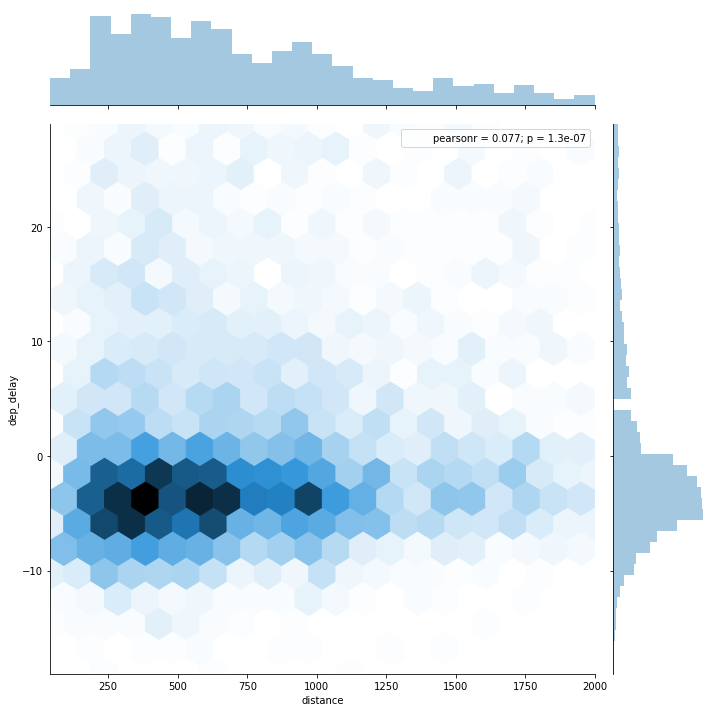

In [27]:
pdf = df.sample(False, 0.02, 20).toPandas()
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind='hex', size=10, joint_kws={'gridsize':20})

In [29]:
import numpy as np

In [35]:
distthresh = flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
delaythresh = flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.02)

In [36]:
distthresh

[31.0, 258.0, 390.0, 501.0, 588.0, 726.0, 908.0, 1062.0, 1337.0, 2105.0]

In [37]:
delaythresh

[-54.0, -7.0, -5.0, -3.0, -2.0, -1.0, 1.0, 6.0, 16.0, 47.0]

In [38]:
results = spark.sql('SELECT COUNT(*) FROM flights' +
                    ' WHERE dep_delay >= 3 AND dep_delay < 8 AND' +
                    ' distance >= 47 AND distance < 557')

results.show()

+--------+
|count(1)|
+--------+
|   12015|
+--------+

